In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [29]:
def boxPlotPPMTopBot(dfOG,dfGB,val,var,yaxis,xaxis):

    #get the top/bot 5 for our top/bot ppm
    dfTop5 = dfGB.drop(['average_ppm','std','count'], axis=1).head(5)
    dfBot5 = dfGB.drop(['average_ppm','std','count'], axis=1).tail(5)
    
    #inner join with original values to get the filtered list
    dfJoinTop = pd.merge(dfOG, dfTop5, left_on=var, right_on=var, how='inner')
    dfJoinBot = pd.merge(dfOG, dfBot5, left_on=var, right_on=var, how='inner')
    
    fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(15,8))

    #plot for top5
    bplotTop=sns.violinplot(y=val, x=var, data=dfJoinTop, width=1, palette="colorblind", cut = 0, ax=axes[0])
    #bplotTop=sns.stripplot(y=val, x=var, data=dfJoinTop, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[0])
    bplotTop.set_xlabel("highest 5 "+xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    
    
    #plot for bot5
    bplotBot=sns.violinplot(y=val, x=var, data=dfJoinBot, width=1, palette="colorblind", cut=0, ax=axes[1])
    #bplotBot=sns.stripplot(y=val, x=var, data=dfJoinBot, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[1])
    bplotBot.set_xlabel("lowest 5 "+xaxis,fontsize=15)
    bplotBot.set_xticklabels(bplotBot.get_xticklabels(),rotation=60)
    bplotBot.set_ylabel(yaxis,fontsize=15)
    bplotBot.tick_params(labelsize=14)
    
    plt.show()
    
def boxPlotPPMAll(df,val,var,yaxis,xaxis,maxTop):
    
    fig, ax = plt.subplots(1,figsize=(7,8))
    #plt.figure(figsize=(7,8))
    bplotTop=sns.violinplot(y=val, x=var, data=df, width=1, palette="colorblind", cut=0, ax=ax)
    #bplotTop=sns.stripplot(y=val, x=var, data=df, jitter=True, marker='o', alpha=0.5, color='black')
    bplotTop.set_xlabel(xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    ax.set_ylim(0, maxTop)
    
    bplotTop.figure
    

In [4]:
cols1 = ['sample_id', 'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 'flashlight_enabled', 'nfc_enabled', 'developer_mode']
dfSettings = prepare('2-datasets/settings.parquet',cols1)

#cols2 = ['id','device_id', 'timestamp', 'battery_level', 'network_status', 'screen_brightness', 'screen_on', 'timezone', 'country_code', 'period', 'size', 'direction', 'ppm']
cols2 = ['id', 'period', 'direction', 'ppm']
dfSamples = prepare('2-datasets/samplesPPM.parquet',cols2)

In [5]:
df_inner = pd.merge(dfSamples, dfSettings, left_on='id', right_on='sample_id', how='inner')

In [6]:
df_inner_droppedDup = df_inner.drop(['id', 'sample_id'], axis=1).drop_duplicates()

In [7]:
df_inner_droppedDup.head(100)

,period,direction,ppm,bluetooth_enabled,location_enabled,power_saver_enabled,flashlight_enabled,nfc_enabled,developer_mode
0,1,-1.0,0.2026,0,1,0,0,0,0
11,2,-1.0,0.1869,0,1,0,0,0,0
60,4,1.0,0.7848,0,1,0,0,0,0
107,5,-1.0,0.1449,0,1,0,0,0,0
118,6,1.0,0.5735,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3048,178,-1.0,0.2103,1,1,0,0,0,0
3128,179,1.0,0.5090,1,1,0,0,0,0
3160,181,1.0,0.6236,1,1,0,0,0,0
3209,182,-1.0,0.3391,1,1,0,0,0,0


In [8]:
def settingsGroupBy(dataframe, var, direction):
    df = dataframe.groupby([var,'direction'])['ppm'].agg(average_ppm='mean', std='std', count='count').reset_index().sort_values(['average_ppm'], ascending=False)
    return df.loc[(df['direction'] == direction)]

dfBluetoothGBPos = settingsGroupBy(df_inner_droppedDup, 'bluetooth_enabled', 1)
dfBluetoothGBNeg = settingsGroupBy(df_inner_droppedDup, 'bluetooth_enabled', -1)

dfLocationGBPos = settingsGroupBy(df_inner_droppedDup, 'location_enabled', 1)
dfLocationGBNeg = settingsGroupBy(df_inner_droppedDup, 'location_enabled', -1)

dfPowerSaverGBPos = settingsGroupBy(df_inner_droppedDup, 'power_saver_enabled', 1)
dfPowerSaverGBNeg = settingsGroupBy(df_inner_droppedDup, 'power_saver_enabled', -1)

dfFlashlightGBPos = settingsGroupBy(df_inner_droppedDup, 'flashlight_enabled', 1)
dfFlashlightGBNeg = settingsGroupBy(df_inner_droppedDup, 'flashlight_enabled', -1)

dfNfcGBPos = settingsGroupBy(df_inner_droppedDup, 'nfc_enabled', 1)
dfNfcGBNeg = settingsGroupBy(df_inner_droppedDup, 'nfc_enabled', -1)

dfDeveloperGBPos = settingsGroupBy(df_inner_droppedDup, 'developer_mode', 1)
dfDeveloperGBNeg = settingsGroupBy(df_inner_droppedDup, 'developer_mode', -1)

df_inner_droppedDup['bluetooth_enabled'] = df_inner_droppedDup['bluetooth_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
df_inner_droppedDup['location_enabled'] = df_inner_droppedDup['location_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
df_inner_droppedDup['power_saver_enabled'] = df_inner_droppedDup['power_saver_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
df_inner_droppedDup['nfc_enabled'] = df_inner_droppedDup['nfc_enabled'].apply(lambda x: "No" if x == 0 else "Yes")


dfBluetoothGBPos['bluetooth_enabled'] = dfBluetoothGBPos['bluetooth_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
dfBluetoothGBNeg['bluetooth_enabled'] = dfBluetoothGBNeg['bluetooth_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
dfLocationGBPos['location_enabled'] = dfLocationGBPos['location_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
dfLocationGBNeg['location_enabled'] = dfLocationGBNeg['location_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
dfPowerSaverGBPos['power_saver_enabled'] = dfPowerSaverGBPos['power_saver_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
dfPowerSaverGBNeg['power_saver_enabled'] = dfPowerSaverGBNeg['power_saver_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
dfNfcGBPos['nfc_enabled'] = dfNfcGBPos['nfc_enabled'].apply(lambda x: "No" if x == 0 else "Yes")
dfNfcGBNeg['nfc_enabled'] = dfNfcGBNeg['nfc_enabled'].apply(lambda x: "No" if x == 0 else "Yes")

  bluetooth_enabled  direction  average_ppm       std   count
1                No        1.0     0.633595  0.396772  239712
3               Yes        1.0     0.593230  0.348144   41556
  bluetooth_enabled  direction  average_ppm       std   count
0                No       -1.0     0.352819  0.412250  264690
2               Yes       -1.0     0.268331  0.303414   56433


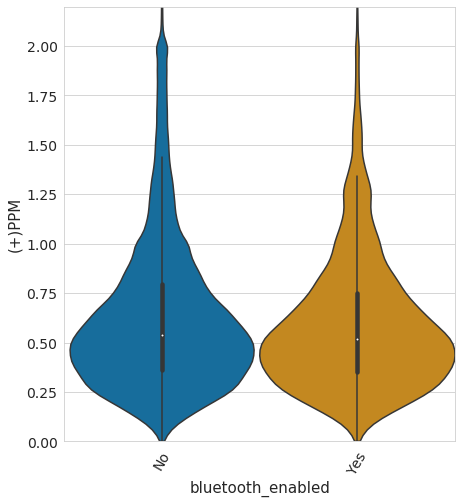

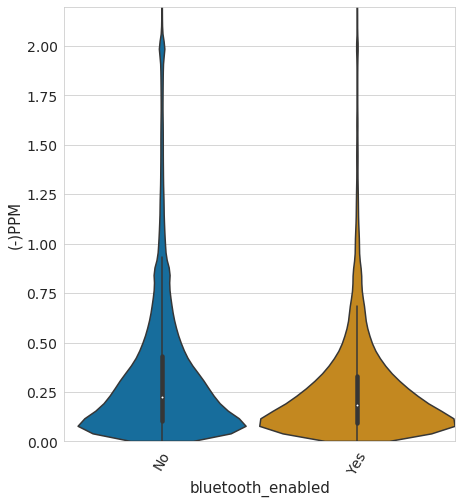

In [37]:
print(dfBluetoothGBPos); 
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == 1)],'ppm','bluetooth_enabled','(+)PPM','bluetooth_enabled', 2.2);
print(dfBluetoothGBNeg);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == -1)],'ppm','bluetooth_enabled','(-)PPM','bluetooth_enabled', 2.2);


  location_enabled  direction  average_ppm       std   count
1               No        1.0     0.636196  0.402969  162222
3              Yes        1.0     0.615960  0.371858  119046
  location_enabled  direction  average_ppm       std   count
0               No       -1.0     0.364095  0.424386  187150
2              Yes       -1.0     0.301477  0.350930  133973


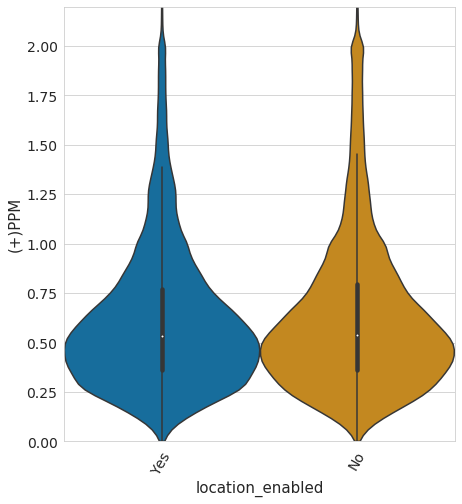

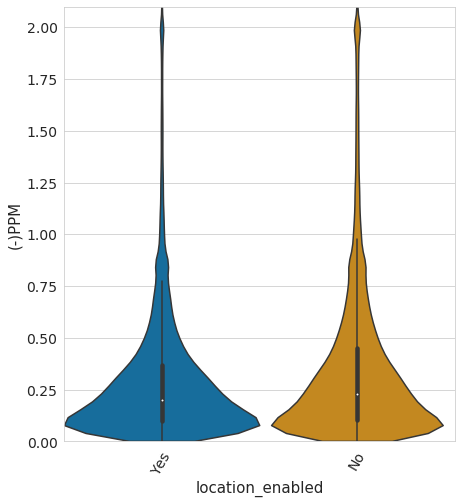

In [35]:
print(dfLocationGBPos); 
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == 1)],'ppm','location_enabled','(+)PPM','location_enabled',2.2);
print(dfLocationGBNeg);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == -1)],'ppm','location_enabled','(-)PPM','location_enabled', 2.1);


  power_saver_enabled  direction  average_ppm       std   count
3                 Yes        1.0     0.669523  0.389889   15026
1                  No        1.0     0.625267  0.390117  266242
  power_saver_enabled  direction  average_ppm       std   count
0                  No       -1.0     0.339647  0.399632  288035
2                 Yes       -1.0     0.323386  0.368898   33088


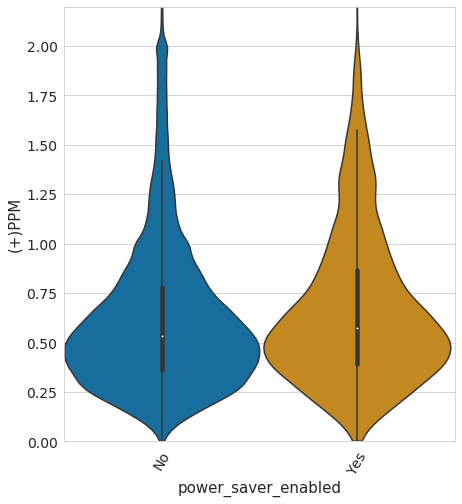

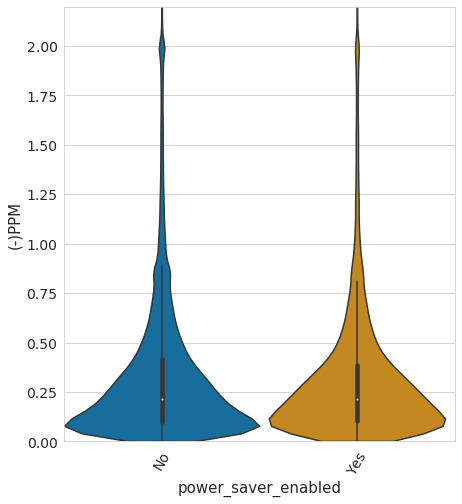

In [39]:
print(dfPowerSaverGBPos); 
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == 1)],'ppm','power_saver_enabled','(+)PPM','power_saver_enabled',2.2);
print(dfPowerSaverGBNeg);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == -1)],'ppm','power_saver_enabled','(-)PPM','power_saver_enabled',2.2);


  nfc_enabled  direction  average_ppm       std   count
3         Yes        1.0     0.677921  0.375394   27809
1          No        1.0     0.622113  0.391433  253459
  nfc_enabled  direction  average_ppm       std   count
0          No       -1.0     0.345341  0.407928  290049
2         Yes       -1.0     0.269180  0.258905   31074


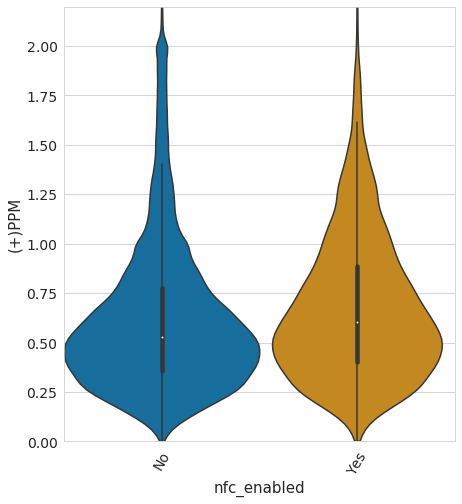

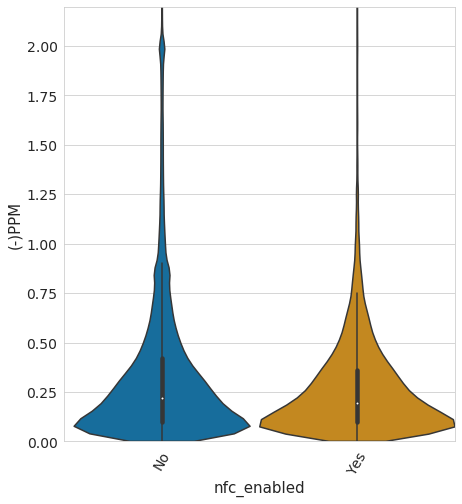

In [40]:
print(dfNfcGBPos); 
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == 1)],'ppm','nfc_enabled','(+)PPM','nfc_enabled',2.2);
print(dfNfcGBNeg);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == -1)],'ppm','nfc_enabled','(-)PPM','nfc_enabled',2.2);


   developer_mode  direction  average_ppm       std   count
3               1        1.0     0.633104  0.414645   26674
1               0        1.0     0.627057  0.387581  254594
   developer_mode  direction  average_ppm       std   count
2               1       -1.0     0.357892  0.425014   34085
0               0       -1.0     0.335606  0.393029  287038


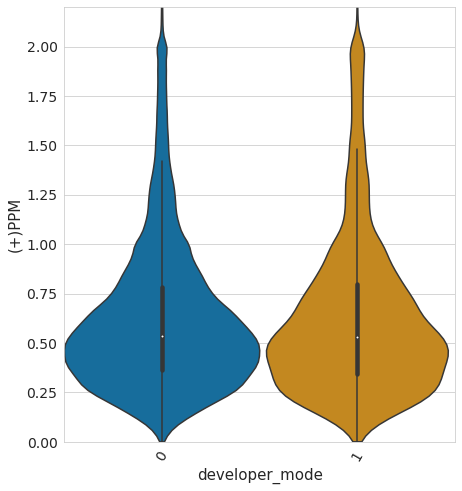

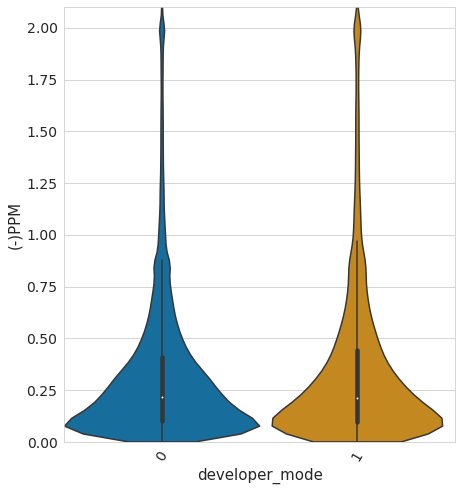

In [42]:
print(dfDeveloperGBPos); 
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == 1)],'ppm','developer_mode','(+)PPM','developer_mode',2.2);
print(dfDeveloperGBNeg);
boxPlotPPMAll(df_inner_droppedDup.loc[(df_inner_droppedDup['direction'] == -1)],'ppm','developer_mode','(-)PPM','developer_mode', 2.1);
